# Lab:  Neural Networks for Music Classification

In addition to the concepts in the [MNIST neural network demo](./demo_mnist_neural.ipynb), in this lab, you will learn to:
* Load a file from a URL
* Extract simple features from audio samples for machine learning tasks such as speech recognition and classification
* Build a simple neural network for music classification using these features
* Use a callback to store the loss and accuracy history in the training process
* Optimize the learning rate of the neural network

To illustrate the basic concepts, we will look at a relatively simple music classification problem.  Given a sample of music, we want to determine which instrument (e.g. trumpet, violin, piano) is playing.  This dataset was generously supplied by [Prof. Juan Bello](http://steinhardt.nyu.edu/faculty/Juan_Pablo_Bello) at NYU Stenihardt  and his former PhD student Eric Humphrey (now at Spotify).  They have a complete website dedicated to deep learning methods in music informatics:

http://marl.smusic.nyu.edu/wordpress/projects/feature-learning-deep-architectures/deep-learning-python-tutorial/

You can also check out Juan's <a href="http://www.nyu.edu/classes/bello/ACA.html">course</a>.



## Loading the PyTorch package
We begin by loading PyTorch and the other packages

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import torch

## Audio Feature Extraction with Librosa

The key to accurate audio classification is to extract good features. In addition to `torch`, we will use the `librosa` package.  The `librosa` package in python has a rich set of audio feature extraction methods for machine learning tasks such as speech recognition and sound classification. 

Installation instructions and complete documentation for the package are given on the [librosa main page](https://librosa.github.io/librosa/).  After you have installed the package, you should be able to import it as follows.

In [2]:
import librosa
import librosa.display
import librosa.feature

In this lab, we will use a set of music samples from the website:

http://theremin.music.uiowa.edu

This website has great files for audio processing.  We will use the `requests.get` and `file.write` commands to load the file from a given URL into the working directory.

In [3]:
import requests
fn = "SopSax.Vib.pp.C6Eb6.aiff"
url = "http://theremin.music.uiowa.edu/sound files/MIS/Woodwinds/sopranosaxophone/"+fn

req = requests.get(url)
with open(fn, "wb") as file:        
    file.write(req.content) # write to file

If the above fails, you may need to install `requests` with `conda install requests`.

Next, we'll use the `librosa` command `librosa.load` to read the audio file with filename `fn` and get the samples `y` and sample rate `sr`.

In [4]:
y, sr = librosa.load(fn)

Let's play the audio file.  You should hear a soprano saxaphone playing four notes (C, C#, D, Eb).

In [5]:
# TODO: play audio file using IPython.display (recall the lab from unit 6)
display(fn)

'SopSax.Vib.pp.C6Eb6.aiff'

Extracting features from audio files is an entire subject on its own right.  A commonly used set of features are called the Mel Frequency Cepstral Coefficients (MFCCs).  These are derived from the so-called "mel" spectrogram, which represents both frequency and power in the log domain.  This is motivated by human perceptual processing, which does something similar.  The code below displays the mel spectrogram of the audio sample.

The spectrogram clearly shows the four notes played in the audio track.  It also shows the "harmonics" of each note, which are the frequency components at integer multiples of the fundamental frequency of each note.

d:\python\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
d:\python\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


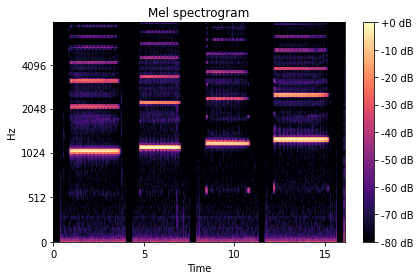

In [6]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.power_to_db(S,ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

## Downloading the Data

Using the MFCC features described above, Eric Humphrey and Juan Bellow have created a complete data set that can used for instrument classification.  Essentially, they collected a number of data files from the website above and, for each audio file, they segmented the track into notes and then extracted 120 MFCCs for each note.  The goal was to recognize the instrument from the 120 MFCCs.  The process of feature extraction is quite involved.  So, we will just use their processed data provided at:

https://github.com/marl/dl4mir-tutorial/blob/master/README.md

Note the password.  Load the four files into some directory, say, `instrument_dataset`.  Then, load the data into numpy arrays as follows.

In [7]:
data_dir = 'instrument_dataset/'
Xtr = np.load(data_dir+'uiowa_train_data.npy')
ytr = np.load(data_dir+'uiowa_train_labels.npy')
Xts = np.load(data_dir+'uiowa_test_data.npy')
yts = np.load(data_dir+'uiowa_test_labels.npy')

From these data files, write code that prints out:
* the number of training and test samples
* the number of features in each sample
* the number of classes (i.e., instruments to recognize)

In [8]:
# TODO
print('The number of training samples: {}, The number of test samples: {}'.format(Xtr.shape[0],Xts.shape[0]))
print('The number of features in each sample: {}'.format(Xtr.shape[1]))
print('The number of classes: {}'.format(np.max(ytr)+1))

The number of training samples: 66247, The number of test samples: 14904
The number of features in each sample: 120
The number of classes: 10


Before continuing, we will standardize the training and test data, `Xtr` and `Xts`.  First compute the mean and std deviation of each feature in `Xtr`.  Then create a new training data set, `Xtr_scale`, by subtracting the feature means from `Xtr` and dividing by the feature std deviations.  Then create a standardized test dataset, `Xts_scale`, **using the mean and std deviation computed on the training dataset**.

In [9]:
# TODO Scale the training and test matrices
# Xtr_scale = ...
Xtr_scale = (Xtr-np.mean(Xtr,axis=0))/np.std(Xtr,axis=0)
# Xts_scale = ...
Xts_scale = (Xts-np.mean(Xtr,axis=0))/np.std(Xtr,axis=0)

## Create DataLoaders

To use PyTorch, we first create a Dataloader using the `TensorDataset` and `DataLoader` commands, just as in the demos. We will use `batch_size = 100`.

In [10]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

batch_size = 100

# TODO Convert the numpy arrays to tensors
Xtr_torch = torch.Tensor(Xtr_scale)
ytr_torch = torch.Tensor(ytr)
Xts_torch = torch.Tensor(Xts_scale)
yts_torch = torch.Tensor(yts)


# TODO Create a training/test dataset from the tensors
# train_ds = ...
train_ds = torch.utils.data.TensorDataset(Xtr_torch, ytr_torch)
# test_ds = ...
test_ds = torch.utils.data.TensorDataset(Xts_torch, yts_torch)
# TODO Create a training/test data loader from datasets
# train_loader = ...
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
# test_loader = ...
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size)
                                           

## Building a Neural Network Classifier

Following the example in [MNIST neural network demo](./mnist_neural.ipynb), create a neural network `model` with:
* `nh=256` hidden units
* `sigmoid` activation

Make sure to select the input and output dimensions correctly, and print the model summary.

In [11]:
import torch.nn as nn

# TODO: construct the model
# nin = ...
nin = Xtr.shape[1]
# nout = ...
nout = int(np.max(ytr)+1)
# nh = ...
nh = 256

# TODO Create Net class
# nin: dimension of input data
# nh: number of hidden units
# nout: number of outputs
# class Net(nn.Module):
class Net(nn.Module):
    def __init__(self,nin,nh,nout):
        super(Net,self).__init__()
        self.sigmoid = nn.Sigmoid()
        self.Dense1 = nn.Linear(nin,nh)
        self.Dense2 = nn.Linear(nh,nout)
        
    def forward(self,x):
        x = self.sigmoid(self.Dense1(x))
        out = self.Dense2(x)
        return out

# Initialize network
# model = Net(nin=nin, nh=nh, nout=nout)
model = Net(nin=nin, nh=nh, nout=nout)

# Print string representation
# print(str(model))
print(str(model))

Net(
  (sigmoid): Sigmoid()
  (Dense1): Linear(in_features=120, out_features=256, bias=True)
  (Dense2): Linear(in_features=256, out_features=10, bias=True)
)


## Training the Network

Next, select an optimizer (linked to the parameters of your new model) and a loss function. For the optimizer, we suggest to start with the Adam optimizer with a learning rate of 0.001.

In [12]:
import torch.optim as optim

lr = 1e-3

# TODO
# opt = ...
opt = optim.Adam(model.parameters(), lr=lr)
# criterion = ...
criterion = nn.CrossEntropyLoss()

Train the model for 10 epochs using the scaled training data.  For **every batch**, record the training loss. 
For **every epoch**, record the training accuracy, the test loss, and the test accuracy.  Use the variable names defined below.  The code should be similar to that in the MNIST demo.

In [13]:
# TODO Train model for 10 epochs
num_epoch = 10
a_tr_loss = []
a_tr_accuracy = []
a_ts_loss = []
a_ts_accuracy = []

for epoch in range(num_epoch):

    model.train() 
    correct = 0 
    total = 0 
    batch_loss_tr = []
    for train_iter, data in enumerate(train_loader):
        x_batch,y_batch = data
        y_batch = y_batch.type(torch.long)
        out = model(x_batch)
        loss = criterion(out,y_batch)
        batch_loss_tr.append(loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()
        _, predicted = torch.max(out.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
        
    a_tr_loss.append(np.mean(batch_loss_tr)) 
    a_tr_accuracy.append(100*correct/total)

    model.eval() 
    correct = 0 
    total = 0 
    batch_loss_ts = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            labels = labels.type(torch.long)
            outputs = model(images)
            batch_loss_ts.append(criterion(outputs,labels).item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    a_ts_loss.append(np.mean(batch_loss_ts))
    a_ts_accuracy.append(100*correct/total)

Plot the test accuracy versus epoch, as saved in `a_ts_accuracy`. You should see a final accuracy $> 99\%$.

Text(0, 0.5, 'accuracy')

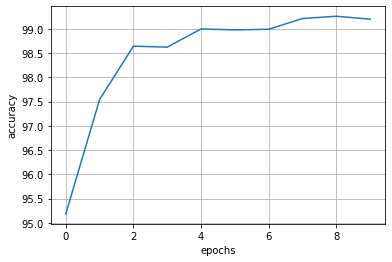

In [14]:
# TODO
# plt.plot(...)
# ...
plt.plot(a_ts_accuracy)
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')

Plot the loss **versus batch**, as saved in `a_tr_loss`, using `semilogy`.  But label the x-axis in units of epochs.  Note that the relation between the epoch and batch index `i` is `epoch = i*batch_size/ntr`, given `batch_size` and a total of `ntr` training samples.

Text(0, 0.5, 'loss')

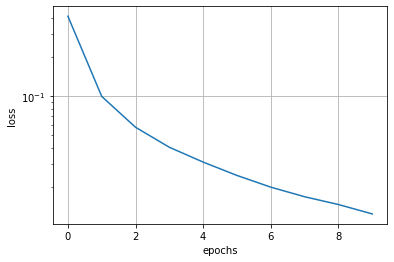

In [18]:
# TODO
# plt.plot(...)
# ...
plt.semilogy(a_tr_loss)
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')

## Optimizing the Learning Rate

One challenge in training neural networks is the selection of the learning rate.  Re-run the above code inside a for loop that trys the 4 learning rates given in the vector `rates`.  For each learning rate:
* instantiate the model (which resets the learned parameters),
* construct the optimizer (i.e., Adam with the appropriate learning rate),
* train the model,
* record the loss versus batch and accuracy versus epoch, as before.

In [31]:
rates = [0.01,0.001,0.0001]
loss_hist = []
val_acc_hist = []

# TODO
for i,rate in enumerate(rates):
    model = Net(nin=nin, nh=nh, nout=nout)
    opt = optim.Adam(model.parameters(), lr=rate)
    criterion = nn.CrossEntropyLoss()
    a_tr_loss = []

    for epoch in range(10):
        model.train()
        correct = 0
        total = 0
        for train_iter, data in enumerate(train_loader):
            x_batch,y_batch = data
            y_batch = y_batch.type(torch.long)
            out = model(x_batch)
            loss = criterion(out,y_batch)
            a_tr_loss.append(loss.item())
            opt.zero_grad()
            loss.backward()
            opt.step()
            _, predicted = torch.max(out.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        model.eval() 
        correct = 0 
        total = 0 
        batch_loss_ts = []
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                labels = labels.type(torch.long)
                outputs = model(images)
                batch_loss_ts.append(criterion(outputs,labels).item())
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
    loss_hist.append(a_tr_loss)

Plot the loss vs. batch index (again labeling the x-axis in units of epochs) for all three learning rates on one graph.  You should see that, at a lower learning rate, the loss is more stable but converges more slowly.

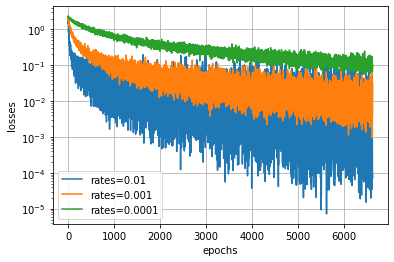

In [32]:
# TODO
labels=['rates=0.01','rates=0.001','rates=0.0001']
for i in range(3):
    plt.semilogy(loss_hist[i],label=labels[i])
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.grid()